# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.emfiles import load_data,crop_fourier_images
from src.jaxops import *
from src.fsc import *
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
star_file = "Extract/job020/particles.star"

params0, imgs_f0 = load_data(data_dir, star_file, True)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:532: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_NAME].str.split("@").str
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:540: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[Relion.IMAGE_ORIGINAL_NAME].str.split("@").str


load_data: number of partcles:  5090
load_data: data loaded, time:  5.904005527496338
load_data: FFT of data, time:  9.556333065032959


In [4]:
print(imgs_f0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(5090, 256, 256)
(5090,)
(5090, 3)
(5090, 2)
(5090, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs_f = imgs_f0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Create the grids

In [7]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873214e-03 2.56000000e+02]


### Crop images to 64 x 64 

In [8]:
nx = 256
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873214e-03 2.56000000e+02]


### Before further processing, vectorize the images, create mask etc

In [9]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(5090, 65536)


In [10]:
jnp.fft.fftshift(jnp.array(imgs_f[101]).reshape(nx,nx))

DeviceArray([[-183.15305    +0.j       ,  148.17178  +142.5803j   ,
              -106.9896    +35.92031j  , ...,   39.41284   -16.370687j ,
              -106.9896    -35.92031j  ,  148.17178  -142.5803j   ],
             [   7.6613293-239.14696j  ,  175.82622  +206.61844j  ,
               -19.568514  -35.122074j , ...,  190.39783  -172.90277j  ,
              -234.38422   -64.62343j  ,   -4.5816574+168.04372j  ],
             [  18.791424 -153.79681j  ,  -81.396675 -370.82706j  ,
               -49.184517  -15.663403j , ..., -110.72281   -55.55396j  ,
               160.28032  -270.17053j  , -178.98264  +195.13356j  ],
             ...,
             [ 101.90088    +1.8292817j,   76.14319  +123.640495j ,
                99.63898   +65.58115j  , ..., -156.99368  +111.28863j  ,
                67.917854 -127.00602j  ,   -1.7144971-201.26596j  ],
             [  18.791424 +153.79681j  , -178.98264  -195.13356j  ,
               160.28032  +270.17053j  , ...,  -17.404694 -273.77478j  ,
 

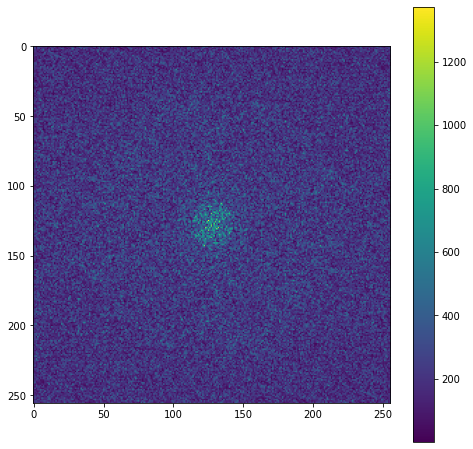

In [11]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

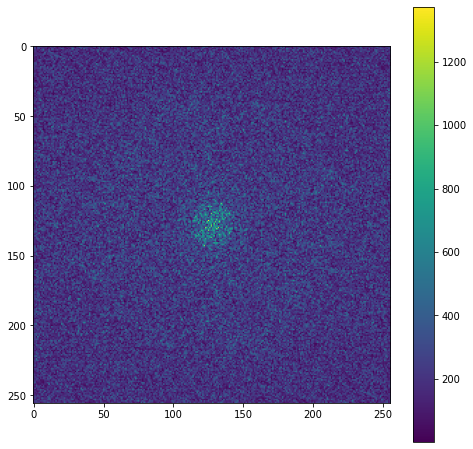

In [12]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

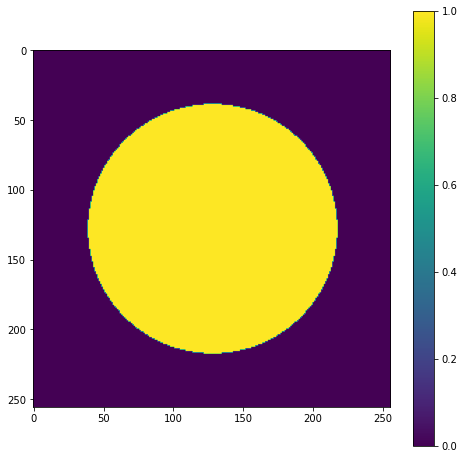

In [14]:
centre = (0,0,0)
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [15]:
alpha = 0.1

slice_func,slice_func_array = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [14]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(65536,)

In [15]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0])
print(time.time()-start)
print(ll.shape)

1.558232069015503
(256, 256, 256)


In [16]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx])
print(time.time()-start)
print(ll.shape)

1.8970131874084473
(256, 256, 256)


### CG

In [17]:
from src.algorithm import conjugate_gradient, get_cg_vol_ops

#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 10

N2 = jnp.floor(N/2).astype(jnp.int64)
#N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape)

In [19]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

Iter 0 ||r|| = 0.0011650020860117334
Iter 1 ||r|| = 0.0002011392325430672
Iter 2 ||r|| = 0.00027557837416694245
Iter 3 ||r|| = 0.0002190401530288659
Iter 4 ||r|| = 0.00011475087867036002
Iter 5 ||r|| = 3.1317002712193167e-05
Iter 6 ||r|| = 8.584685323630408e-05
Iter 7 ||r|| = 6.306157002457833e-05
Iter 8 ||r|| = 3.8501232450164324e-05
Iter 9 ||r|| = 1.9883170370572955e-05


In [26]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

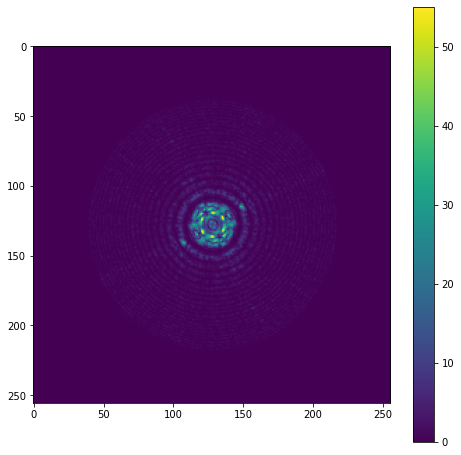

In [27]:
i = 110
s0 = slice_func(vcg1, angles[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

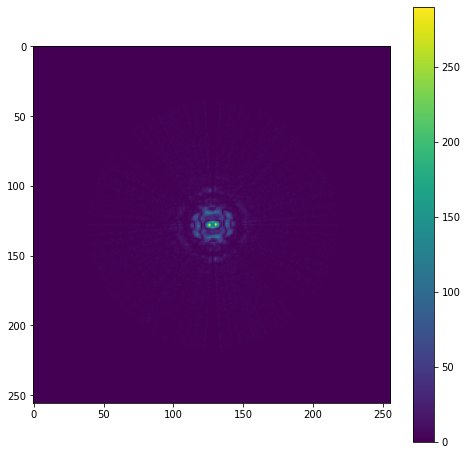

In [28]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

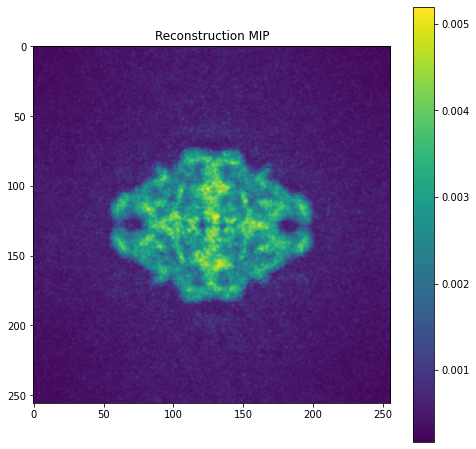

In [29]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [30]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

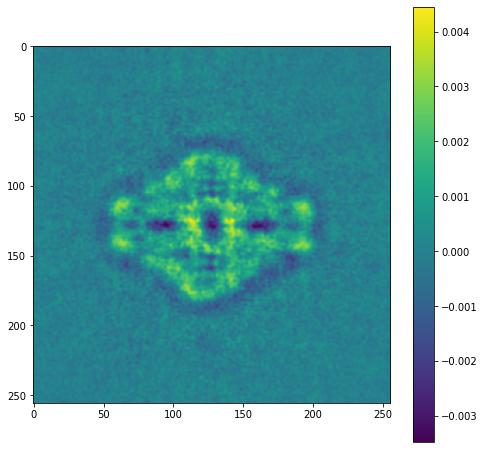

In [31]:
plt.imshow(vr1[:,:,128]); plt.colorbar()

### Write volume to file

In [33]:
#with mrcfile.new('../data/reconstruction_full_data.mrc', overwrite=True) as mrc:
#    mrc.set_data(vr1.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [34]:
vcg2=vcg1

In [38]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


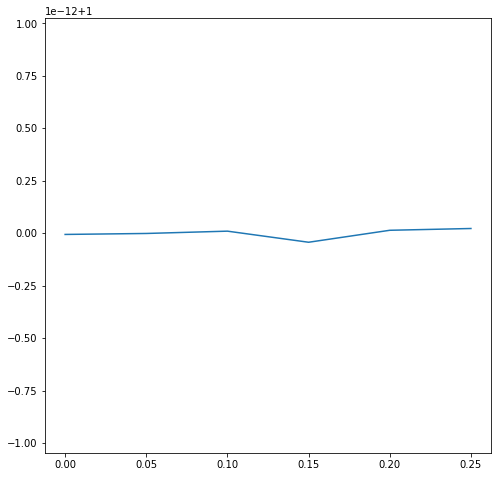

In [39]:
plt.plot(res,fsc)

In [45]:
points_v_tri = points_orientations_tri(angles[:50], x_grid[1])

In [46]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

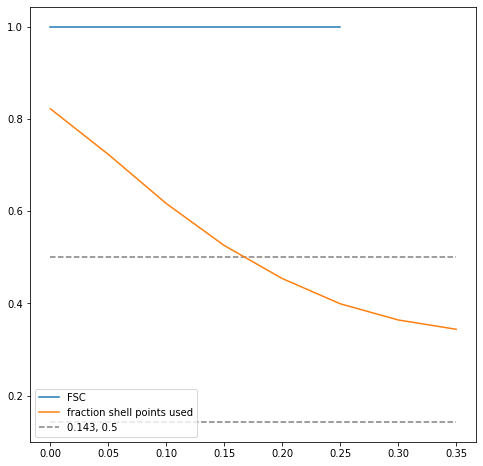

In [47]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

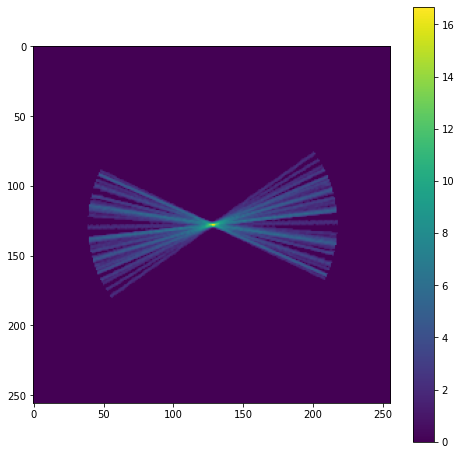

In [48]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

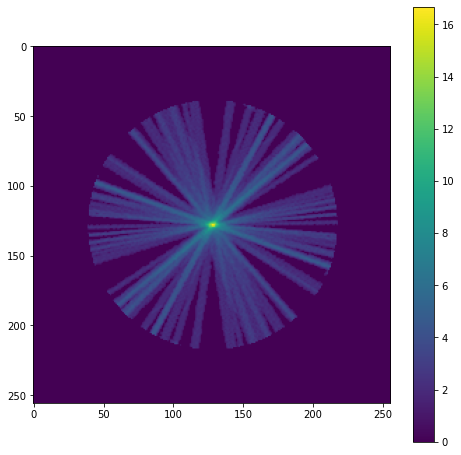

In [49]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

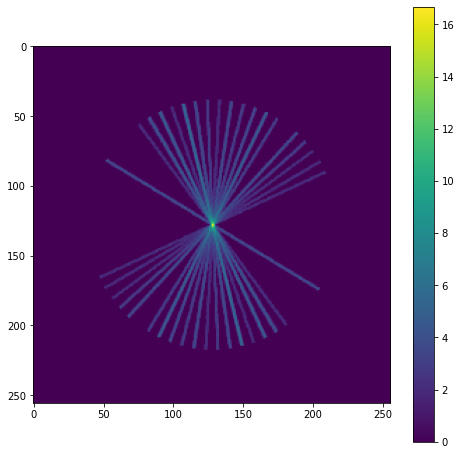

In [50]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [51]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

RuntimeError: Resource exhausted: Out of memory while trying to allocate 34024980784 bytes.

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()